In [1]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import datetime
import os
from pprint import pprint
import matplotlib.pyplot as plt
import time
import vectorbtpro as vbt
from time import time
import helpers as pth
import platform
from dotenv import load_dotenv
import scipy.stats as stats

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

plt.style.use("classic")
# plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]


if platform.system().lower() == "windows":
    base_data_path = "H:\\phitech-data\\01_raw"
else:
    from core_chains.simple.llm import make_Q_chain

    base_data_path = "../../phitech-data/01_raw"
    load_dotenv("../../sandatasci-core/credentials")
    Q = make_Q_chain("gpt-4o-instance1", __vsc_ipynb_file__)

In [24]:
I = pth.load_instruments(base_path=base_data_path)
I.keys()

dict_keys(['6B', 'MES'])

### Information Coefficient

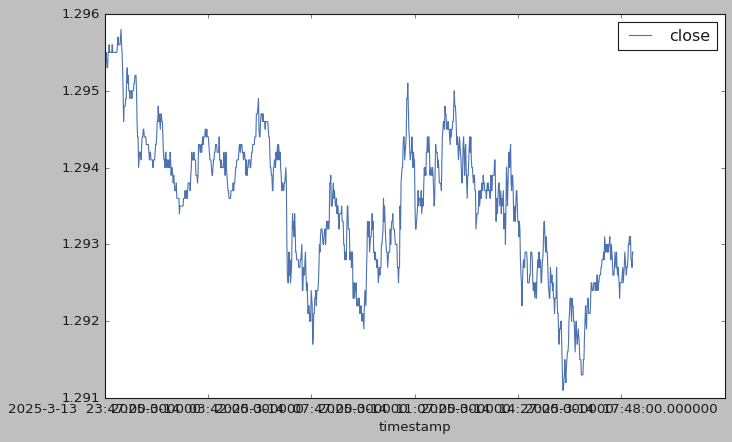

In [25]:
df = I["6B"].iloc[-1024:][["close"]]
df.plot()
plt.show()

In [26]:
periods = range(5, 65, 5)
for p in periods:
    df[f"frets_{p}"] = df.close.pct_change(-p)

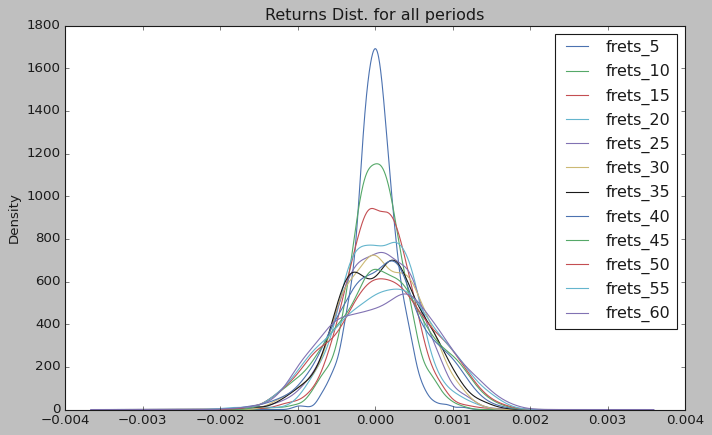

In [27]:
df.dropna(inplace=True)
for p in periods:
    df[f"frets_{p}"].plot(
        kind="kde", legend=True, title="Returns Dist. for all periods"
    )
plt.show()

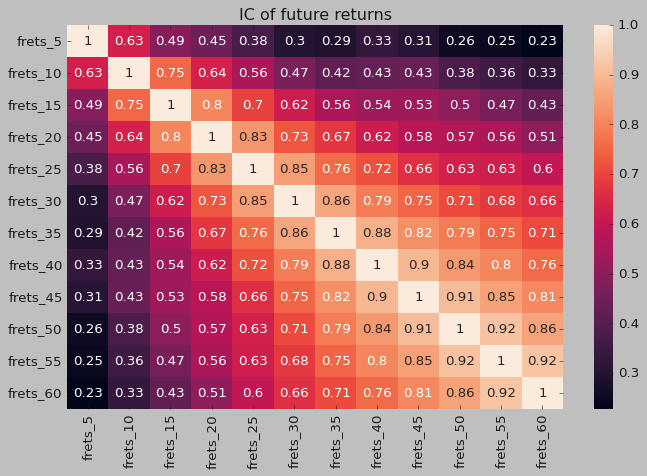

In [28]:
import seaborn as sns

cmatrix = df[[c for c in df.columns if c != "close"]].corr(method="spearman")
sns.heatmap(cmatrix, annot=True)
plt.title("IC of future returns")
plt.show()

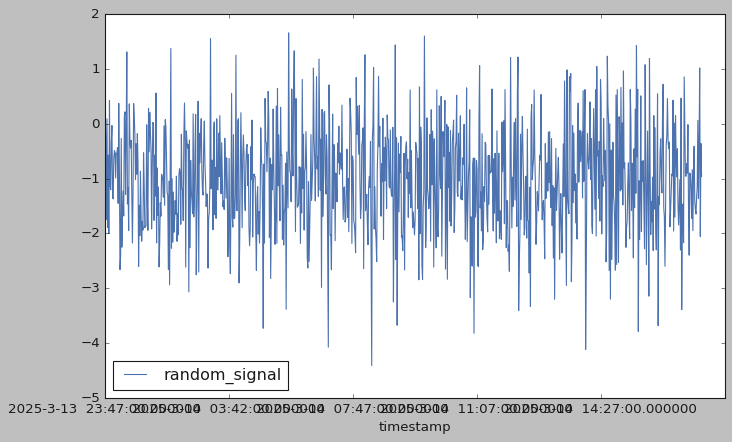

In [29]:
df["random_signal"] = np.random.normal(-1, 1, size=df.shape[0])
df.random_signal.plot(legend=True)
plt.show()

In [30]:
print("-------CORRELATION OF RANDOM_SIGNAL WITH FUTURE RETURNS-------\n")
for c in df.columns:
    if "rets" in c:
        current = stats.spearmanr(df["random_signal"], df[c])
        print(f"IC for C={c} -> {current.statistic}")

-------CORRELATION OF RANDOM_SIGNAL WITH FUTURE RETURNS-------

IC for C=frets_5 -> -0.0011325279157779796
IC for C=frets_10 -> -0.008815881832310742
IC for C=frets_15 -> 0.011315898491975937
IC for C=frets_20 -> 0.03181390414532093
IC for C=frets_25 -> 0.04498179887961835
IC for C=frets_30 -> 0.03607457483302001
IC for C=frets_35 -> 0.015289880631052653
IC for C=frets_40 -> 0.02925974507295835
IC for C=frets_45 -> 0.03958179563388999
IC for C=frets_50 -> 0.04569908628736822
IC for C=frets_55 -> 0.049330677740651786
IC for C=frets_60 -> 0.05769507479849642


### Rolling Information Coefficient

In [80]:
res = df[["frets_5", "random_signal", "frets_10"]]
res

,frets_5,random_signal,frets_10
timestamp,,,
2025-3-13 23:47:00.000000,0.000077,0.033908,-0.000077
2025-3-13 23:49:00.000000,0.000077,0.409129,-0.000077
2025-3-13 23:51:00.000000,-0.000077,-0.267724,-0.000077
2025-3-13 23:53:00.000000,0.000000,-1.748164,0.000000
2025-3-13 23:54:00.000000,-0.000154,0.089326,-0.000077
...,...,...,...
2025-3-14 17:06:00.000000,-0.000155,-0.410248,-0.000309
2025-3-14 17:07:00.000000,-0.000155,1.016313,-0.000232
2025-3-14 17:08:00.000000,-0.000155,-2.058264,-0.000232


count    905.000000
mean       0.619065
std        0.093968
min        0.384418
25%        0.552693
50%        0.626209
75%        0.688640
max        0.848486
Name: frets_5, dtype: float64
TtestResult(statistic=np.float64(139.39694523254758), pvalue=np.float64(0.0), df=np.float64(1807.982524547707))


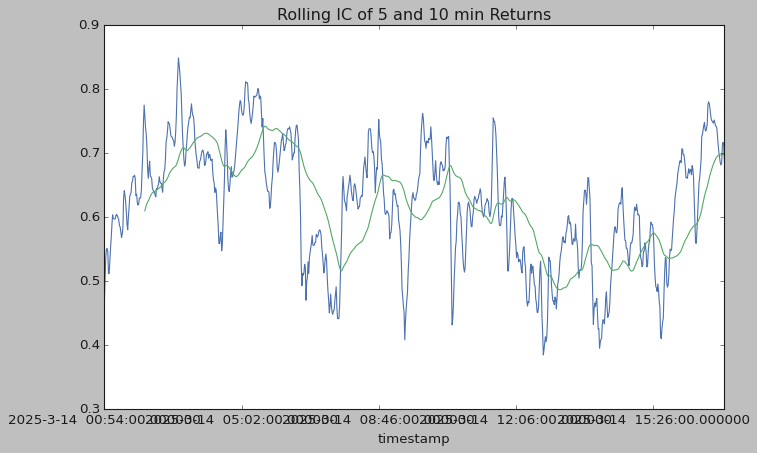

In [141]:
def plot_rolling_IC(col="frets_5"):
    rolling_rets = (
        df[col]
        .rolling(window=60)
        .apply(
            lambda x: abs(stats.spearmanr(x, df.frets_10.loc[x.index]).statistic),
            raw=False,
        )
        .dropna()
    )
    print(rolling_rets.describe())
    noise = pd.Series(
        np.random.normal(0, rolling_rets.std(), size=rolling_rets.shape[0])
    )
    print(
        stats.ttest_ind(
            rolling_rets.dropna(),
            noise,
            equal_var=False,
        )
    )
    rolling_rets.plot(title="Rolling IC of 5 and 10 min Returns")
    rolling_rets.rolling(window=60).mean().plot()
    plt.show()


plot_rolling_IC("frets_5")

count    905.000000
mean       0.114003
std        0.078429
min        0.000028
25%        0.046786
50%        0.105411
75%        0.165770
max        0.372922
Name: random_signal, dtype: float64
TtestResult(statistic=np.float64(32.247012935340784), pvalue=np.float64(1.3369065259240233e-180), df=np.float64(1807.315576997954))


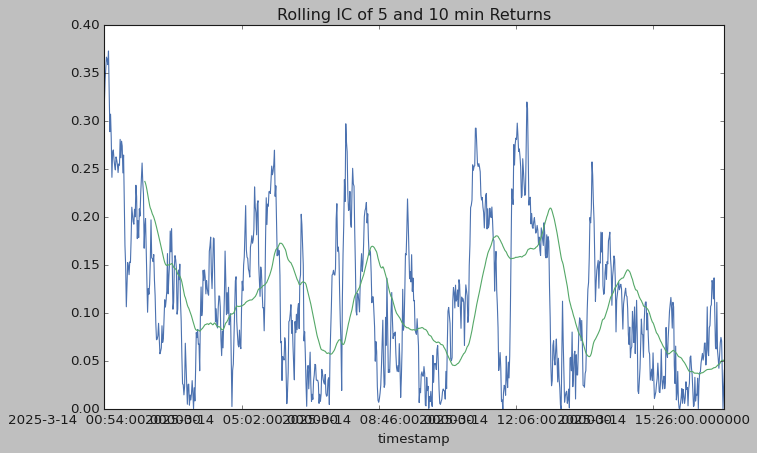

In [142]:
plot_rolling_IC("random_signal")